# Innledning
I denne *Computational Essay* for FYS1120, skal vi utdype oss i hvordan solenoider funker, samt gå gjennom solenoidens historie og hvordan den kan brukes. Videre skal vi se på hovedbudskapet om at en solenoide faktisk har null felter, både det magnetiske og det elektriske feltet i systemet, ved å visualisere og tilpasse variablene. Det ble brukt *KI-basert verktøy* for å rette på eventuelle feil med grammatikk eller budskapet i essayen, samt hjelpe med å utvikle simuleringsprogrammene.

## Formålet med essayen
Formålet med denne essayen er å besvare spørsmål som dreier seg om hvordan en solenoide fungerer. Blant de spørsmålene man kan komme på med, er det disse spørsmålene som skal utforskes og besvares i denne essayen:

 - Er det mulig å finne ut om det magnetiske feltet fra en solenoide går mot null? I så fall, under hvilke betingelser?
 - Hvilke faktorer påvirker styrken til det magnetiske feltet fra en solenoide?
 - Hvordan kan beregningsmodeller og simuleringer brukes til å undersøke forholdene der det magnetiske feltet går mot null? 

## Solenoide -- kort forklart

Solenoiden er en isolert leder bygget som en tettviklet spole. Når strøm tilføres systemet, vil den danne et elektromagnetisk felt rundt solenoiden. Det dannes altså et magnetisk felt rundt og langs aksen til solenoiden. Dette kan brukes til å danne om elektrisk energi til mekanisk energi ved bruk av magnetisk kraft. En solenoide er i essens en spole og kan dermed brukes til å lagre energi i magnetfeltet den danner.

Det finnes 2 foskjellige soleniode som ekstierer i markende det enten "valve eller electric". Begge i prinsippe har egenskapen ved å dytte eller hente materialen den er polet til Solenoiden. Komponenten kan brukes i en rekke forskjellige systemer, det er mulig å bruke solenoide som endringer mellom forskjellige spenninger ved bygging av transformatorer og generatorer for generering av strøm.

%%latex
\newpage

# Fremgangsmåte
I denne *Computational Essay* skal det kjøres simuleringer i Python av magnetfeltet fra en solenoide sett fra tre forskjellige planer: $(x,y)$-, $(y,z)$- og $(x,z)$-planet. Det magnetiske feltet rundt en solenoide skal også utregnes. Deretter skal det kjøres et seperat program som leter etter mørke soner i alle tre planer. En *rød* sone er altså der den magnetiske feltstyrken $\|\mathbf{B}\|$ er lik null.

Det er hovedsakelig kun én størrelse som blir brukt i dette prosjektet: det magnetiske feltet $\mathbf{B}$.

## Magnetisk felt fra en strømførende leder (Biot-Savarts lov)
For en strømførende leder med kurve $C$, så er det magnetiske feltet
sett fra et vilkårlig punkt $\mathbf{r}$ i rommet gitt ved

\begin{align*}
\mathbf{B}(\mathbf{r}) = \frac{\mu_0}{4\pi} \int_C{\frac{I \, d\mathbf{l} \times \left(\mathbf{r} - \mathbf{l}\right)}{\left\|\mathbf{r} - \mathbf{l}\right\|^3}}
\end{align*}

der $I$ er strømmen, $d\mathbf{l}$ er linjeelementet til
lederen og $\mu_0$ er vakuumpermeabiliteten. Dette uttrykket vil være nyttig
da en spiralkurve best tilnærmer en solenoide.


## Kode for simulasjoner i planer
Her skal det stå definisjoner som er felles for alle simuleringer i denne Computational Essay. Funksjonene som brukes i alle simuleringer er som følger:
 - `bfieldlist` regner ut feltstyrken fra en kurve som leder strømm, sett fra et punkt i rommet
 -  `beregn_b_felt` regner ut feltstyrken i rommet, sett fra et plan i rommet
 -  `plottingsone` plotter feltstyrken og feltlinjene på et gitt plan

In [17]:
#!/usr/bin/env python3
# -*- code: utf-8 -*-

"""
En bibliotek som inneholder felles rutiner
og definisjoner som tas i bruk i numeriske
utregninger for Computational Essay i
FYS1120 - semester H 2024
"""


# Eksterne biblioteker
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange  # type: ignore
from typing import Optional


# Konstanter
mu0 = 4 * np.pi * 1.0e-7  # Permeabilitiet i vakuum (T * m / A)
I = 1.0  # Strømmen gjennom solenoiden (A)

# --- Metoder --- #

# Metode for å regne ut magnetisk feltstyrke
# fra en strømførende leder
# - bruker eksemplet fra pensum: Chapter 11.1
# "Elementary Electromagnetism Using Python"
# - optimalisert ved bruk av Numba
@njit
def bfieldlist(r: np.ndarray, koordinater: np.ndarray, i: float) -> np.ndarray:
    """
    Regner ut vektoren for den magnetiske feltstyrken
    ved punktet `r` fra en strømførende leder.

    Argumenter:
        r: np.ndarray
            Punkt i rommet
        koordinater: np.ndarray
            Liste med alle punkter på lederkurven
        i: float = I
            Strømmen gjennom lederen
    """

    # Start med en nullvektor for feltvektoren
    B = np.zeros(3)

    # Hent antall punkter i angitt lederkurve
    N = koordinater.shape[0]

    # Regn ut bidraget fra hvert punkt i lederkurven
    for n in range(N):
        # Regn ut det magnetiske feltet for en lukket sløyfe
        n0 = n
        n1 = (n + 1) % N  # Sikrer at vi går tilbake til start

        # Midtpunktet til segmentet
        mid = (koordinater[n1] + koordinater[n0]) / 2

        # Regn ut vektorer
        R_vec = r - mid  # Avstandsvektor
        dlv = koordinater[n1] - koordinater[n0]  # Linjeelement
        norm_R = np.linalg.norm(R_vec)  # Normalisert avstandsvektor

        # Regn ut differensialelementet for det magnetiske feltet
        # og regn ut netto magnetisk felt styrke ved å summere
        # opp differensialelementer
        dB = (mu0 * i / (4 * np.pi)) * np.cross(dlv, R_vec) / np.power(norm_R, 3)
        B += dB

    # Returner feltet
    return B


# Metode for å regne ut magnetisk feltstyrke over
# et rutenett (grid)
# - optimalisert ved bruk av Numba (parallellkjøring)
@njit(parallel=True)
def beregn_B_felt(
    X: np.ndarray, Y: np.ndarray, Z: np.ndarray, koordi: np.ndarray, i: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Regner ut magnetisk feltstyrke over et rutenett (grid)

    Argumenter:
        X: np.ndarray
            Liste med x-koordinater
        Y: np.ndarray
            Liste med y-koordinater
        Z: np.ndarray
            Liste med z-koordinater
        koordi: np.ndarray
            Liste med punkter på lederkurven
        i: float = I
            Strøm gjennom lederen
    """

    # Initialiser tre lister for hvert
    # komponent i feltvektoren
    Bx = np.zeros_like(X)
    By = np.zeros_like(X)
    Bz = np.zeros_like(X)

    # Regn ut feltstyrken for hvert punkt i planet
    for u in prange(X.shape[0]):
        for v in range(X.shape[1]):
            r = np.array([X[u, v], Y[u, v], Z[u, v]])
            B = bfieldlist(r, koordi, i)
            Bx[u, v] = B[0]
            By[u, v] = B[1]
            Bz[u, v] = B[2]

    return Bx, By, Bz


# Metode for å plotte magnetisk feltstyrke
def plottingsone(
    B1: np.ndarray,
    B2: np.ndarray,
    axis1: np.ndarray,
    axis2: np.ndarray,
    navn: list[str],
    farge: str,
    R: Optional[float] = None,
    L: Optional[float] = None,
    tol: float = 1.0e-7,
) -> None:
    """
    Plotter magnetisk feltstyrke på et plan

    Argumenter:
        B1: np.ndarray
            Første komponent i feltvektoren
        B2: np.ndarray
            Andre komponent i feltvektoren
        axis1: np.ndarray
            Første akse i planet
        axis2: np.ndarray
            Andre akse i planet
        navn: str
            Navn til akser på figuren
        farge: str
            Farge til feltlinjene
        R: Optional[float] = None
            Solenoidens radius
        L: Optional[float] = None
            Solenoidens lengde
        tol: float = 1.0e-6
            Toleranse der verdier under den
            betraktes til å være tilnærmet
            lik null
    """

    # Lag en figur
    plt.figure(figsize=(5,4))
    plt.tight_layout()
    
    # Plott feltstyrken i et arealområde
    B_magnitude = np.sqrt(B1 ** 2 + B2 ** 2)
    contour = plt.contourf(axis1, axis2, B_magnitude * 1.0e6, levels=50, cmap="viridis")
    cbar = plt.colorbar(contour, ax=plt.gca())
    cbar.set_label("Magnetfeltstyrke ($\\mu$T)")

    # Plott feltlinjene på planet
    plt.streamplot(axis1, axis2, B1, B2, color=farge, density=1.5)

    # Finn punktene der feltstyrken er lik null
    zero_field = B_magnitude <= tol  # Områder med felt under terskelverdien

    # Plott områdene med feltstyrke under terskelen
    plt.contourf(axis1, axis2, zero_field, levels=[tol, 1], colors="red", alpha=0.5)

    #Alternativt
    # # Finn punktene der begge feltkomponentene er lik null
    # zero_indices = np.where((np.abs(B1) <= tol) & (np.abs(B2) <= tol))

    # # Plott nullpunktene
    # plt.scatter(
    #     axis1[zero_indices],
    #     axis2[zero_indices],
    #     color="red",
    #     marker=".",
    #     label="Nullpunkt",
    # )
    # Legg til fargesøyle
    cbar = plt.colorbar()
    cbar.set_label("$|B| = 0$")

    plt.xlabel(f"{navn[1]} (m)")
    plt.ylabel(f"{navn[2]} (m)")

    title = f"B-felt rundt en solenoide i {navn[0]}-planet"

    if (R) and (not L):
        title += f" ({R=})"
    elif (not R) and (L):
        title += f" ({L=})"
    elif R and L:
        title += f" ({R=}, {L=})"

    plt.title(title) #Added inn the title since it was not counted in
    plt.grid(True)

# Magnetfeltet fra en enkel solenoide
Her skal det kontrolleres om metodene funker som de skal. Det skal altså simuleres en enkel soleniode og magnetfeltet skal plottes i $(x,z)$- $(y,z)$- og $(x,y)$-planet. En solenoide som er på $z$-aksen kan parametriseres ved
\begin{align*}
    x &= R\cos\theta \\
    y &= R\sin\theta \\
    z &= \frac{\theta - N\pi}{2\pi N} L
\end{align*}
der $R$ er radiusen til solenoide, $L$ er lengden til solenoiden, $N$ er antall viklinger og $\theta \in [0, 2\pi N]$ er vinkelen på $(x,y)$-planet. Denne modellen er teknisk sett ikke lukket, så 

Calulating B-field on XZ-plane
Calulating B-field on YZ-plane
Calulating B-field on XY-plane
Completed


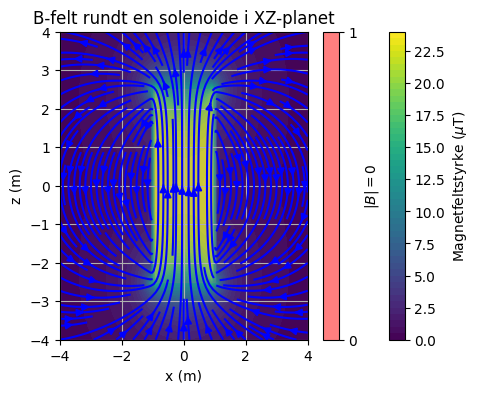

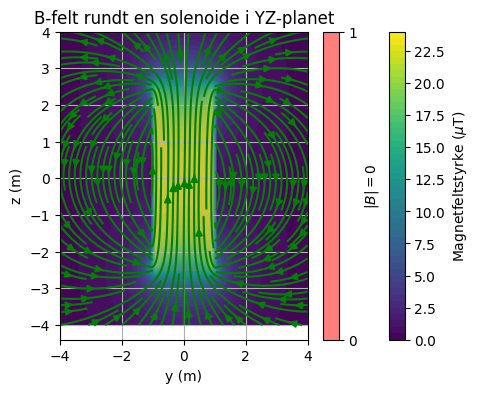

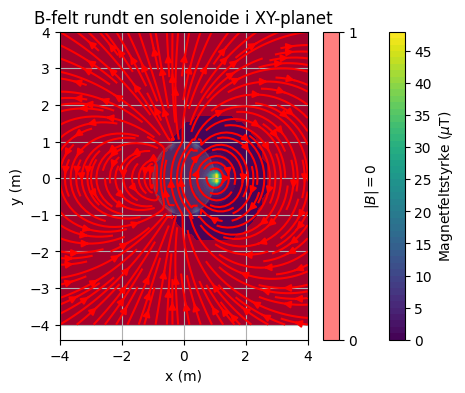

In [18]:

# Konstanter
I = 1.0  # Strøm gjennom solenoiden
R = 1.0  # Radius av solenoiden
N = 100  # Antall viklinger
L = 5.0  # Lengden på solenoiden
n = N / L  # Antall viklinger per lengdeenhet

# Parametere for solenoiden
radius = R
lengde = L
antall_punkter = 5000

# Oppretter koordinatene til solenoiden
theta = np.linspace(0, 2 * np.pi * N, antall_punkter)
z = L * (theta - N * np.pi) / (2 * np.pi * N)
x = R * np.cos(theta)
y = R * np.sin(theta)
koordinater = np.column_stack((x, y, z))

# Lager standard på alle planene
steg = 50
line = 4
x = np.linspace(-line, line, steg)
z = np.linspace(-line, line, steg)
y = np.linspace(-line, line, steg)

# --- for XZ-planet--- med blå
X, Z = np.meshgrid(x, z)
Y = np.zeros_like(X)
#Sier ut progressen
print(f"Calulating B-field on XZ-plane")

# Beregner magnetfeltet ved hvert punkt i gridet
Bx, By, Bz = beregn_B_felt(X, Y, Z, koordinater, I)
navnXZ = ["XZ", "x", "z"]
plottingsone(Bx, Bz, X, Z, navnXZ, "b")
# Tegner solenoiden
plt.fill_between([-R, R], -L / 2, L / 2, color="gray", alpha=0.3)

# --- for YZ-planet--- med grønn
# Definerer grid i YZ-planet
Y, Z_ = np.meshgrid(y, z)
X = np.zeros_like(Y)

#Sier ut progressen
print(f"Calulating B-field on YZ-plane")

# Beregner magnetfeltet ved hvert punkt i gridet
Bx, By, Bz = beregn_B_felt(X, Y, Z_, koordinater, I)
navnYZ = ["YZ", "y", "z"]
plottingsone(By, Bz, Y, Z_, navnYZ, "g")
# Tegner solenoiden
plt.fill_between([-R, R], -L / 2, L / 2, color="gray", alpha=0.3)

# --- for XY-planet--- med rød
# Definerer grid i XY-planet
X_, Y_ = np.meshgrid(x, y)
Z = np.zeros_like(X_)

#Sier ut progressen
print(f"Calulating B-field on XY-plane")

# Beregner magnetfeltet ved hvert punkt i gridet
Bx, By, Bz = beregn_B_felt(X_, Y_, Z, koordinater, I)
navnXY = ["XY", "x", "y"]
plottingsone(Bx, By, X_, Y_, navnXY, "r")
# Tegner solenoiden
sirkel = plt.Circle((0, 0), R, color="gray", alpha=0.3)
plt.gca().add_artist(sirkel)

#Sier ifra fredig
print(f"Completed")

plt.show()


Man kan se at feltstyrken er identisk, sett fra $(x,z)$- og $(y,z)$-planet, da en ideell solenoide har sylindrisk symmetri. Ideelt sett skal det ikke være feltlinjer på $(x,y)$-planet men siden modellen som ble brukt i koden ikke er en perfekt modell, vil feltstyrken sett fra $(x,y)$-planet se ujevn ut.

# Kan endringer i solenoidens størrelse skape nuller i magnetfeltstyrken?

I tidligere undersøkelser ble det analysert en solenoide med en bestemt størrelse for å forstå hvordan magnetfeltet ser ut under vanlige forhold. Imidlertid vil det interessant å utforske hva som vil skje med magnetfeltet dersom solenoidens dimensjoner endres, enten ved å øke eller redusere dens radius og lengde. Man kan bruke Biot-Savarts lov for å utforske dette:

$$
\mathbf{B}(\mathbf{r}) = \frac{\mu_0}{4\pi} \int_C \frac{I \, d\mathbf{l} \times \left(\mathbf{r} - \mathbf{l}\right)}{\|\mathbf{r} - \mathbf{l}\|^3}
$$

Formelen tar hensyn til lengden på solenoiden over tid, noe som innebærer at endringer i geometriske parametere kan påvirke det resulterende magnetfeltet. En større solenoid vil typisk generere et sterkere magnetfelt (B-felt) på grunn av den økte lengden av lederne gjennom hvilke strømmen går, noe som igjen kan være den resulterer til oppdannelse av dødzoner i B feltet på solenoiden. For å visualisere og analysere konseptet, bruker vi de tidligere kodene oppe som viser forskjeller i B-feltet i ulike plan, for eksempel XY- og XZ-planene. Ved addere nye kodene, en effektiv metode for gjøre alle plottene er å separere radius og lengde som separate lister, og deretter bruker en for-loop til å plotte magnetfeltet i ulike kombinasjoner av disse parameterne. På denne måten kan man simulere og sammenligne tre forskjellige størrelser, enten ved å variere lengden eller radiusen, og dermed få innsikt hvordan endringer i rekke størrelsen påvirker magnetfeltet. 


## Kode for en solenoide med varierende størrelse

Calulating B-field (R = 1.0 and L = 3.0)
Calulating B-field (R = 1.0 and L = 5.0)
Calulating B-field (R = 1.0 and L = 7.0)
Calulating B-field (R = 1.0 and L = 5.0)
Calulating B-field (R = 2.0 and L = 5.0)
Calulating B-field (R = 3.0 and L = 5.0)
Completed


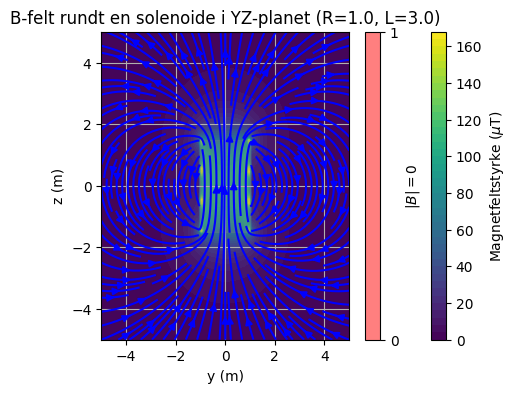

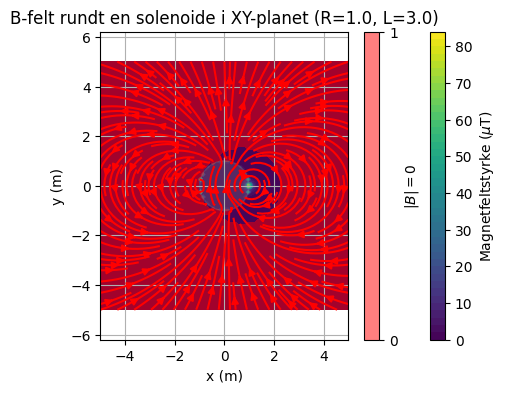

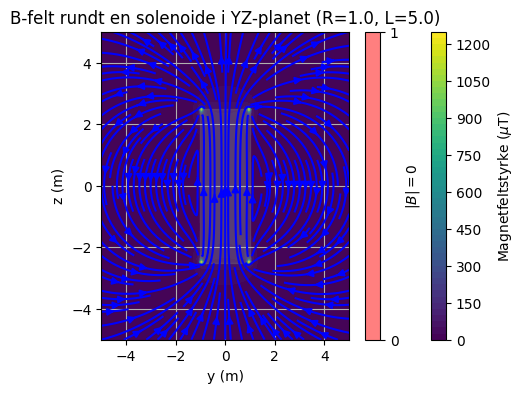

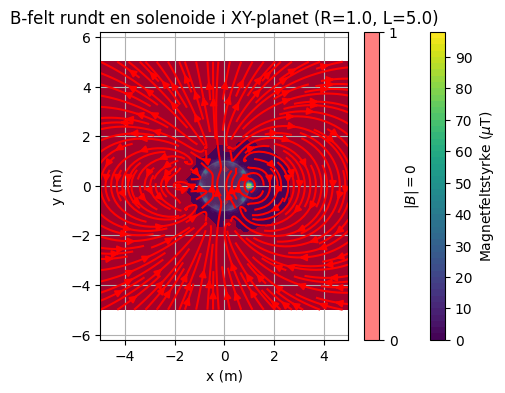

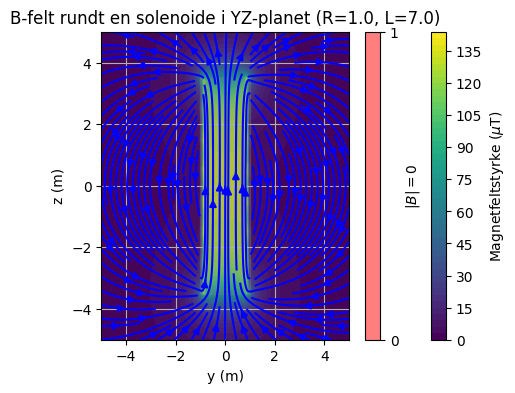

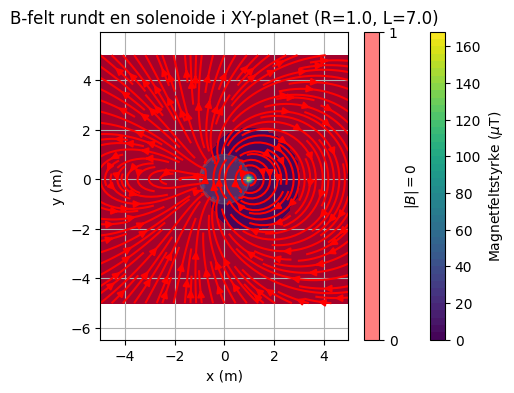

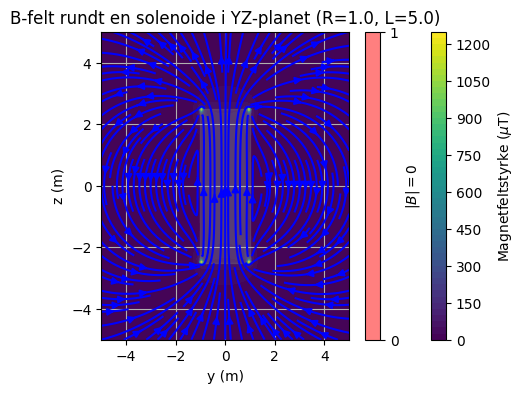

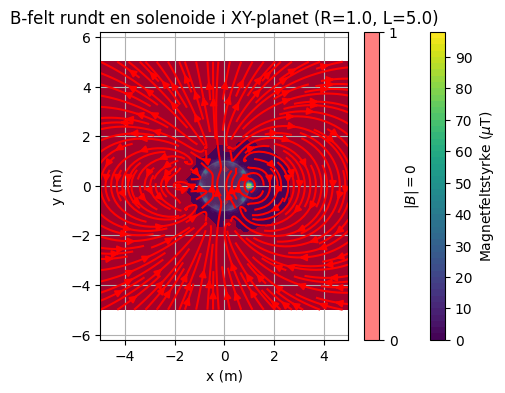

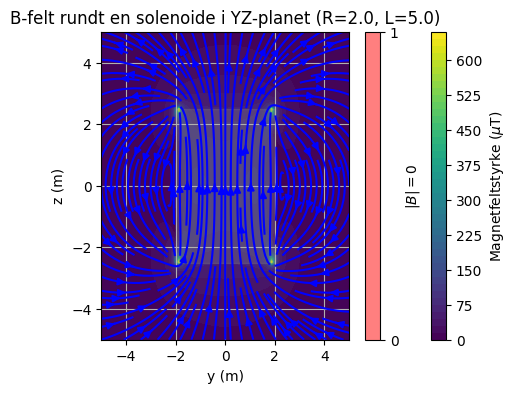

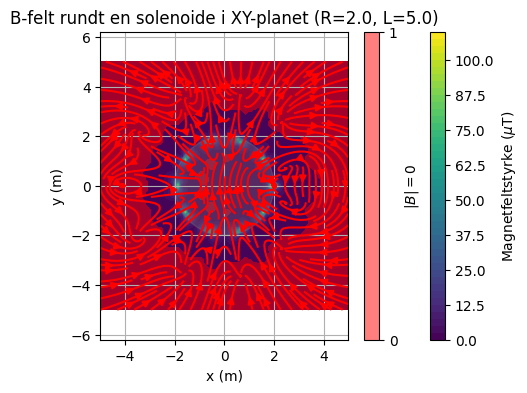

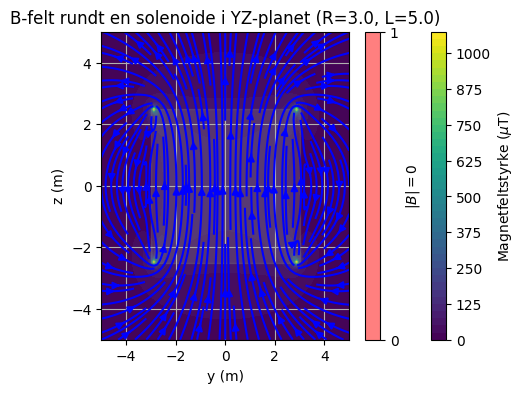

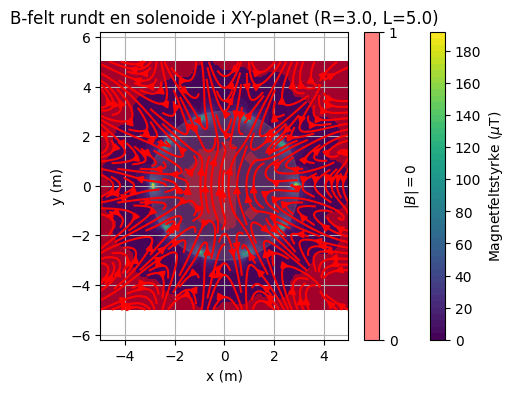

In [19]:
# Konstanter
I = 1.0  # Strøm gjennom solenoiden
n = 100  # Antall viklinger per meter
# Parametere for solenoiden for med sikker nummer
antall_punkter = 5000

# Definerer grid
steg = 100
line = 5
x = np.linspace(-line, line, steg)
z = np.linspace(-line, line, steg)
y = np.linspace(-line, line, steg)


""" 
Endringer på lengde eller radiusen gjøres på 
radius_liste og lengde_liste
"""
# Liste over forskjellige radius og lengder samt standarer
radius_liste = [1.0, 2.0, 3.0]  # endre disse for endre r
standard_radius = [1.0]
lengde_liste = [3.0, 5.0, 7.0]  # endre disse for endre lengden
standard_lengde = [5.0]


def cal(L_liste, R_liste):
    """
     Hoved kalklulasjonene til å plotte ut B-feltet
    R_liste: array
        Listen til vedlagt radius
    L_liste : array
        Listen til vedlagt lengde
    """
    for L in L_liste:
        # Denne tar hensyn med økinger av lengde øking øker og virkinger
        # Oppdaterer antall viklinger per lengdeenhet
        for R in R_liste:
            radius = R
            lengde = L

            #Sier ut progressen til kalklulasjonen
            print(f"Calulating B-field (R = {radius} and L = {lengde})")
            
            # Oppretter koordinatene til solenoiden
            theta = np.linspace(0, 2 * np.pi * n * L, antall_punkter)
            z_solenoid = np.linspace(-lengde / 2, lengde / 2, antall_punkter)
            x_solenoid = radius * np.cos(theta)
            y_solenoid = radius * np.sin(theta)
            koordinater = np.column_stack((x_solenoid, y_solenoid, z_solenoid))

            # *** Plot i YZ-planet ***
            # Definerer grid i YZ-planet
            Y_grid, Z_grid = np.meshgrid(y, z)
            X_grid = np.zeros_like(Y_grid)

            # Beregner magnetfeltet ved hvert punkt i gridet
            Bx, By, Bz = beregn_B_felt(X_grid, Y_grid, Z_grid, koordinater, I)

            navnYZ = ["YZ", "y", "z"]
            plottingsone(By, Bz, Y_grid, Z_grid, navnYZ, "b", radius, lengde)
            # Tegner solenoiden
            plt.fill_between([-R, R], -L / 2, L / 2, color="gray", alpha=0.3)

            # *** Plot i XY-planet ***
            # Definerer grid i XY-planet
            X_grid, Y_grid = np.meshgrid(x, y)
            Z_grid = np.zeros_like(X_grid)

            # Beregner magnetfeltet ved hvert punkt i gridet
            Bx, By, Bz = beregn_B_felt(X_grid, Y_grid, Z_grid, koordinater, I)

            navnXY = ["XY", "x", "y"]
            plottingsone(Bx, By, X_grid, Y_grid, navnXY, "r", R, L)
            # Tegner solenoiden
            sirkel = plt.Circle((0, 0), R, color="gray", alpha=0.3)
            plt.gca().add_artist(sirkel)
            plt.axis("equal")


"""
Kalkulerer B feltet ved forskjellige typer
"""
cal(lengde_liste, standard_radius)
cal(standard_lengde, radius_liste)
print("Completed") #Added the completion
plt.show()


Det vi ser ved ikke endre på virkinger i systemet blir jo interssant med den med radiusen. Der den ble svakere over større radius. Men i lengde økte ikke heller B-feltstyrken. Som da igjen kan være pga. ikke økinger i virkinger i lengden. Så om det skal økes på lengden må den også øker også virklinger for den kontinuerlig. Det også må OBS over at vi øker ikke antall punkter den kan kalkulere seg rundt solenoiden. Mer øking med den øker jo mer data i solenoiden, resultere mer detalijert data.

# Hva skjer dersom man kobler solenoider i serie og parallell?
Ettersom at solenoiden i normal og variert skapte interessant endringer i XY. Er det noe vi skriver mer nede i diskusjonen. Det kan gjøre prøve supplere ut som delt opp serie og paraelle kobling i solenoider. Dette  kan indikere at vår B-felt funskjon i den 0 område kan sette utslag der det ikke skal være. Dette gjør av lage to objekter i lik størrelse ( i denne tilfelle er de halvert i to for en sammenlagt solenoide). Der plottes inn ved bruk av plt.ledgend. Det også gjort større sjanse for null B felt er å gjøre om polene til motsatt hverandre. Resulterer kanselerer seg hverandre.  ( skriv resultatet her). Er det mulighet lage da serie og paraellekoblinger til null B felt? 

## Kode til seriekoblede solenoider
Her skal det analyseres to solenoider som er koaksielle, eller "seriekoblede".

|B(0, 0, 0)| = 0.000 uT
|B(0, 0, 0)| = 0.000 uT
|B(0, 0, 0)| = 0.000 uT


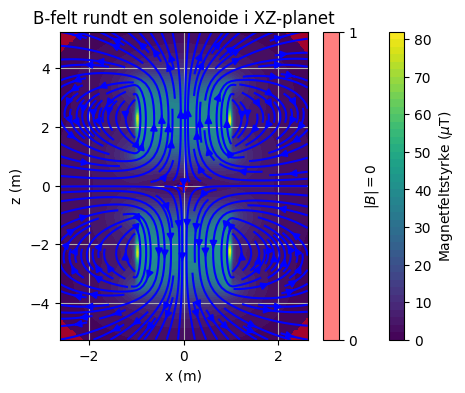

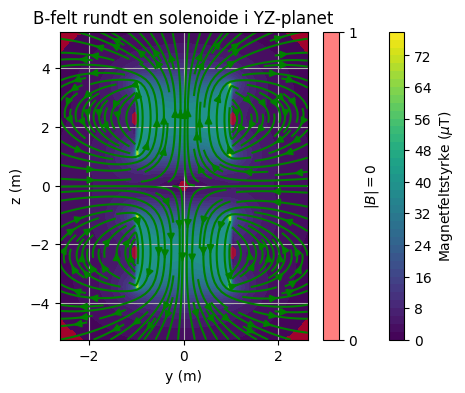

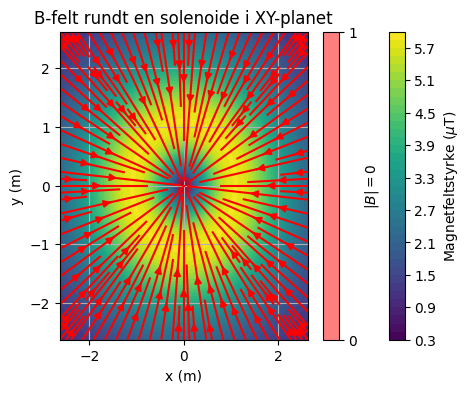

In [20]:
# Konstanter og parametre
I = 1.0  # Strøm gjennom solenoiden
R = 1.0  # Radius av solenoiden
N = 100  # Antall viklinger
L = 2.5  # Lengden på solenoiden
n = 5000  # Antall punkter
z0 = 1.0  # Avstand fra xy-planet

# Størrelsene på planene
steg = 100  # Antall steg
line_v = 1.5 * (z0 + L)  # Verdikal størrelse på plottet
line_h = line_v / 2  # Horisontal størrelse på plottet

# - koordinatene på planene
px = np.linspace(-line_h, line_h, steg)
py = np.linspace(-line_h, line_h, steg)
pz = np.linspace(-line_v, line_v, steg)

# - xy-planet
_x, _y = np.meshgrid(px, py)
_z = np.zeros_like(_x)
p_xy = [_x, _y, _z]

# - yz-planet
_y, _z = np.meshgrid(py, pz)
_x = np.zeros_like(_y)
p_yz = [_x, _y, _z]

# - xz-planet
_x, _z = np.meshgrid(px, pz)
_y = np.zeros_like(_z)
p_xz = [_x, _y, _z]

del _x, _y, _z

# Vinkel for en enkel solenoide
theta = np.linspace(0, 2 * np.pi * N, n)

# Koordinatene til solenoide nr. 1
# - rotasjon mot klokka
x1 = R * np.cos(theta)
y1 = R * np.sin(theta)
z1 = z0 + L * theta / (2 * np.pi * N)

k1 = np.column_stack((x1, y1, z1))

# Koordinatene til solenoide nr 2.
# - speilvendt om xy-planet,
#   rotasjon med klokka
x2 = R * np.cos(-theta)
y2 = R * np.sin(-theta)
z2 = -z1

k2 = np.column_stack((x2, y2, z2))

# Liste med planer
planer = [
    (p_xz, [0, 2], ["XZ", "x", "z"], "b"),
    (p_yz, [1, 2], ["YZ", "y", "z"], "g"),
    (p_xy, [0, 1], ["XY", "x", "y"], "r"),
]

# Regn ut feltstyrken fra begge solenoider, sett
# fra xz-, yz- og xy-planet
for plan, indeks, navn, farge in planer:
    # Regn ut feltstyrken fra hver solenoide
    B1 = beregn_B_felt(plan[0], plan[1], plan[2], k1, I)
    B2 = beregn_B_felt(plan[0], plan[1], plan[2], k2, I)

    # Hent fram relevante komponenter og regn ut
    # netto feltstyrke
    B1_ax1, B1_ax2 = B1[indeks[0]], B1[indeks[1]]
    B2_ax1, B2_ax2 = B2[indeks[0]], B2[indeks[1]]
    B_ax1, B_ax2 = B1_ax1 + B2_ax1, B1_ax2 + B2_ax2
    ax1, ax2 = plan[indeks[0]], plan[indeks[1]]

    # Regn ut feltstyrken i origo og skriv den ut
    origo = np.zeros(3)
    B_origo = bfieldlist(origo, k1, I) + bfieldlist(origo, k2, I)

    print("|B(0, 0, 0)| = %.3f uT" % (np.linalg.norm(B_origo) * 1.0e6))

    # Plott feltstyrken ved bruk av metoden `plottingsone`
    plottingsone(B_ax1, B_ax2, ax1, ax2, navn, farge, tol=1.0e-6)

plt.show()

## Kode til parallellkoblede solenoider
Her skal det analyseres to solenoider som er parallelle i rommet.

|B(0, 0, 0)| = 1.979 uT
|B(0, 0, 0)| = 1.979 uT
|B(0, 0, 0)| = 1.979 uT


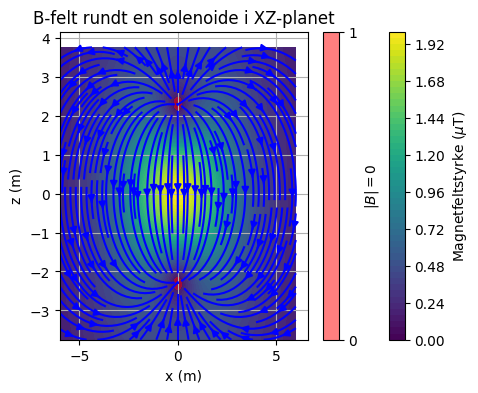

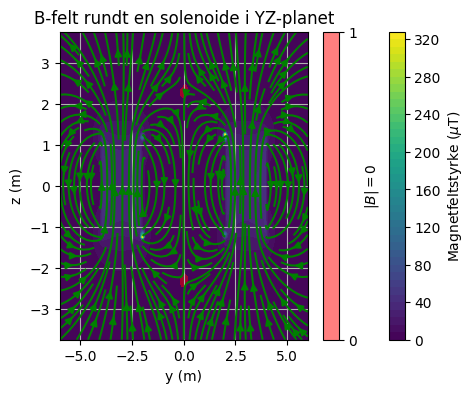

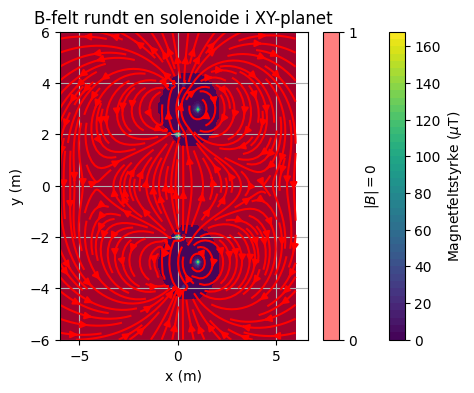

In [21]:
# Konstanter og parametre
I = 1.0  # Strøm gjennom solenoiden
R = 1.0  # Radius av solenoiden
N = 100  # Antall viklinger
L = 2.5  # Lengden på solenoiden
n = 5000  # Antall punkter
y0 = 2.0  # Avstand fra xz-planet

# Størrelsene på planene
steg = 100  # Antall steg
line_h = 1.5 * (y0 + 2 * R)  # Horisontal størrelse på plottet
line_v = 1.5 * L  # Verdikal størrelse på plottet

# - koordinatene på planene
px = np.linspace(-line_h, line_h, steg)
py = np.linspace(-line_h, line_h, steg)
pz = np.linspace(-line_v, line_v, steg)

# - xy-planet
_x, _y = np.meshgrid(px, py)
_z = np.zeros_like(_x)
p_xy = [_x, _y, _z]

# - yz-planet
_y, _z = np.meshgrid(py, pz)
_x = np.zeros_like(_y)
p_yz = [_x, _y, _z]

# - xz-planet
_x, _z = np.meshgrid(px, pz)
_y = np.zeros_like(_z)
p_xz = [_x, _y, _z]

del _x, _y, _z

# Vinkel for en enkel solenoide
theta = np.linspace(0, 2 * np.pi * N, n)

# Koordinatene til solenoide nr. 1
# - rotasjon mot klokka
x1 = R * np.cos(theta)
y1 = (y0 + R) + R * np.sin(theta)
z1 = L * (theta - N * np.pi) / (2 * np.pi * N)

k1 = np.column_stack((x1, y1, z1))
I1 = I

# Koordinatene til solenoide nr 2.
# - speilvendt om xy-planet,
#   rotasjon med klokka
x2 = R * np.cos(theta)
y2 = -(y0 + R) + R * np.sin(theta)
z2 = z1

k2 = np.column_stack((x2, y2, z2))
I2 = I

# Liste med planer
planer = [
    (p_xz, [0, 2], ["XZ", "x", "z"], "b"),
    (p_yz, [1, 2], ["YZ", "y", "z"], "g"),
    (p_xy, [0, 1], ["XY", "x", "y"], "r"),
]

# Regn ut feltstyrken fra begge solenoider, sett
# fra xz-, yz- og xy-planet
for plan, indeks, navn, farge in planer:
    # Regn ut feltstyrken fra hver solenoide
    B1 = beregn_B_felt(plan[0], plan[1], plan[2], k1, I1)
    B2 = beregn_B_felt(plan[0], plan[1], plan[2], k2, I2)

    # Hent fram relevante komponenter og regn ut
    # netto feltstyrke
    B1_ax1, B1_ax2 = B1[indeks[0]], B1[indeks[1]]
    B2_ax1, B2_ax2 = B2[indeks[0]], B2[indeks[1]]
    B_ax1, B_ax2 = B1_ax1 + B2_ax1, B1_ax2 + B2_ax2
    ax1, ax2 = plan[indeks[0]], plan[indeks[1]]

    # Regn ut feltstyrken i origo og skriv den ut
    origo = np.zeros(3)
    B_origo = bfieldlist(origo, k1, I1) + bfieldlist(origo, k2, I2)

    print("|B(0, 0, 0)| = %.3f uT" % (np.linalg.norm(B_origo) * 1.0e6))

    # Plott feltstyrken ved bruk av metoden `plottingsone`
    plottingsone(B_ax1, B_ax2, ax1, ax2, navn, farge, tol=1.0e-7)

plt.show()

# Diskusjon
Vi ser ut ifra dataene vi har funnet ved den serie se at den tass inn imidten . Som gis riktig ved de to solonoidene i mellom de to dras inn til origo , men ved strørrelsen kan det være den eten dratt opp eller ned istedet. Men vi for forskjeller i XZ og YZ når det plottes ut. Men det kan hende det lages variasjon ved lukket bane i solenoiden. Ved den lukket bane vil 
$$
\oint_C{\mathbf{B}\cdot d\mathbf{l}} = 0 
$$
Medføre at ene siden av planet der indre har mer stryke enn andre siden av planet, istedet har ytre kanten har sterkere. Lage moentant styrke til den selve farten til objektet hvis den satt gjennom inni solenoiden. Dette sett av at overfalten til ytre solenoiden ikke har endret størrelse ,som ikke er og uniformelt.  En avvik som ble oppdaget at økingen i solenoiden resulterte lavere feltstyrke i lengden selv med vi satt inn økingen av virkinger. Dette kan være resultatet av vi har tatt forhold mellom virkinger over lengde. Som da skapte lavere Feltstyrke i lengden. 

Videre i XY ser det i alle unntatt i serie slår i utslag ved den ene feltstyrken kommer kun ene siden av sirkelen på den høyre siden. Som solenoide vil det skulle være fult styrke i hele solenoiden. Det kan hende at vi "skjærer" midten av solenoiden som da gir sånn resultat. En annen teori er at den selve solenoiden linjen går jo ifra ring hele veien som skaper en høypunkt ifra ene punktet når den går oppover gjennom den theta $\theta$. Som da skaper en stor avvik i systemet/ null B felt. Dette gjelder også med hvor mye punkter den tar siden vi ser ifra 5000 punkter i hele ringen, ved den kan det øke gi mer uniformelt ladning?

Ved serie og paraelle der vi satt to forskjellige poler ser vi at det kommer null felter i der to av står mot hverandre( spesielt i origo av serie koblingen kan man se null punkt). Vi får igjen samme problemer i XY på den paraelle delen, mens i XZ og YZ har vist to nullpunkter der polene kanserlere seg hver for seg. 

I sammenlagt, trengs det mer sikker håntering av dataene ved at PCene kan ikke håndtere nok kalkulasjonene eller modellfeil i plotten. Eten være mer effektivt i kodene eller feilsøke koden om hva som har skjedd for å forsette prosjektet om det faktisk er null. 

# Konklusjon
Fra det vi har funnet om det er mulig at det finnes null $\mathbf{B}$- felt i hele systemet så ble det oppdaget at det kan ikke fullstedig konkludere det faktisk kan være null B-felt ved nåværende PC pga. kapasistet og begrensinger PC kan kakulere seg frem til mer sikkre svar. Fra det som fikk ut av systemet som ble lagt ble det observert at det er noe null Magnetiske felt i rundt XY planet ved Z = null. Både i vanlige, varierte størrelser og serie/paraelle koblinger.

De rekke mulige feilkilder som kan medfører usikkerheter eller kritiske påvirkninger til simuleringer vi har funnet. Men hoved problemer gjenstår gjennom den kalkulasjonen med 0 B-felt, Denne presentere store deler av prosjeketet og ser store usikkerheter i XY planet spesielt. Eten er det toleransen vi må ta hensyn, hvor mye mer punkter er blir nøyaktiv eller er hvordan vi plassere XY planet. Men det tas inn videre utforsking for optiamlisere eller og eliminere usikkheter,  

Gjennom alt det har fulgt forståelse av:
* Hensyn hvordan en solenoide virker og hva den brukt til
* Produsere ut en plotting hvordan den Magnetiske feltet i solenoide ser ut
* Se null B felt skal være og se etter flere varianter som skaper B felt
* Drøfte ut datene som ble gitt ut se etter problemer som har oppstått 


## Kildeføring
- Fakta om Solenoide - https://snl.no/solenoid
- Utvidelse av Soleniode - https://ccoils.com/blog/what-is-a-solenoid/ 
- Deler av Bfieldlist kodesnittet kom fra boken " Elementary Electromagnetism Using Python", Anders Malthe-Sørenssen

## Prosjektmappe
Prosjektet kan finnes i GitHub: https://github.com/Hai-bit/Project_Zero_HaiJohn/